In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import datetime
from typing import Callable, Optional
from typing import Dict

import matplotlib.pyplot as plt
import torch
import numpy as np


In [2]:
def compute_mean_and_std(loader: DataLoader, dim: list, device="cpu") -> tuple[torch.Tensor, torch.Tensor]:
    """
    Вычисление среднего значения и стандартного отклонения в наборе данных.

    Args:
        loader (DataLoader): DataLoader для итерации по набору данных
        dim (list): Размерности, по которым будут считатья значения
        device (str): Устройство, на котором выполняются вычисления ("cpu" или "cuda").

    Returns:
        tuple[torch.Tensor, torch.Tensor]: Кортеж, содержащий тензоры среднего значения и стандартного отклонения.
    """
    # 1 Создаем список из всех тензоров
    inputs_list = []
    for inputs, _ in loader:
        inputs_list.append(inputs)

    # 2 Соединяем все тензоры в один большой тензор
    all_inputs = torch.cat(inputs_list, dim=0).float().to(device)  # Преобразуем в float и перемещаем на устройство

    # 3 Вычисляем mean и std
    mean = torch.mean(all_inputs, dim=dim)
    std = torch.std(all_inputs, dim=dim)

    return mean, std



class ModelEvaluator:
    """
    A class to evaluate a PyTorch model on given datasets.
    """

    def __init__(self, model: nn.Module, device: torch.device):
        """
        Initializes the ModelEvaluator.

        Args:
            model: The PyTorch model to evaluate.
            device: The device to perform evaluation on (e.g., 'cuda' or 'cpu').
        """
        self.model = model
        self.device = device
        self.model.to(self.device)  # Move model to the specified device

    def evaluate_dataset(self, loader: DataLoader) -> Dict[str, float]:
        """
        Evaluates the model on a given dataset and returns a dictionary of metrics.

        Args:
            loader: The DataLoader for the dataset.

        Returns:
            A dictionary containing evaluation metrics, e.g., {"accuracy": 0.95}.
        """
        self.model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, target in loader:
                inputs, target = inputs.to(self.device), target.to(self.device)  # Move data to device
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, dim=1)  # Get predictions
                correct += (predicted == target).sum().item()  # Count correct predictions
                total += target.size(0)  # Count total number of samples

        accuracy: float = correct / total
        return {"accuracy": accuracy}

    def evaluate(self, train_loader: DataLoader, val_loader: DataLoader) -> Dict[str, Dict[str, float]]:
        """
        Evaluates the model on train and validation datasets and returns a dictionary of metrics.

        Args:
            train_loader: The DataLoader for the training dataset.
            val_loader: The DataLoader for the validation dataset.

        Returns:
            A dictionary containing evaluation metrics for both training and validation datasets,
            e.g., {"train": {"accuracy": 0.90}, "val": {"accuracy": 0.95}}.
        """
        print(f"Evaluating on device {self.device}.")
        metrics = {}
        metrics["train"] = self.evaluate_dataset(train_loader)
        metrics["val"] = self.evaluate_dataset(val_loader)
        return metrics



class Trainer:
    """
    A class to encapsulate the training loop for a PyTorch model.

    Args:
        model: The neural network model to train.
        optimizer: The optimizer to use for training.
        loss_fn: The loss function to use.
        train_loader: The DataLoader for the training data.
        device: The device to train on (CPU or GPU).
        clip_grad_norm: Optional value to clip gradients to. Defaults to None.
        print_interval:  How often to print the training loss. Defaults to 10.
    """

    def __init__(
        self,
        model: nn.Module,
        optimizer: optim.Optimizer,
        loss_fn: nn.Module,
        train_loader: DataLoader,
        device: torch.device,
        clip_grad_norm: Optional[float] = None,
        print_interval: int = 10,
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_loader = train_loader
        self.device = device
        self.clip_grad_norm = clip_grad_norm
        self.print_interval = print_interval

        self.model.to(self.device)  # Move the model to the device in the constructor

    def train_one_batch(self, inputs: torch.Tensor, target: torch.Tensor) -> float:
        """Trains the model on a single batch of data.

        Args:
            inputs: The input tensor.
            target: The target tensor.

        Returns:
            The loss value for the batch.
        """
        self.model.train()  # Ensure the model is in training mode

        self.optimizer.zero_grad(set_to_none=True)  # More efficient if possible

        outputs = self.model(inputs)
        loss = self.loss_fn(outputs, target)

        loss.backward()

        if self.clip_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)  # Gradient clipping

        self.optimizer.step()

        return loss.item()

    def train_epoch(self, epoch_num: int = 0) -> float:
        """Trains the model for one epoch.

        Args:
            epoch_num: The current epoch number (for logging).  Defaults to 0.

        Returns:
            The average loss for the epoch.
        """
        self.model.train()  # Ensure the model is in training mode
        loss_train = 0.0
        num_batches = len(self.train_loader)
        for batch_idx, (inputs, target) in enumerate(self.train_loader):
            inputs = inputs.to(self.device)
            target = target.to(self.device)
            loss_train += self.train_one_batch(inputs, target)

        return loss_train / num_batches

    def training_loop(self, n_epochs: int) -> None:
        """Executes the main training loop.

        Args:
            n_epochs: The number of epochs to train for.
        """
        print(f"Training on device {self.device}.")

        for epoch in range(1, n_epochs + 1):
            avg_loss = self.train_epoch(epoch)

            if epoch == 1 or epoch % self.print_interval == 0:
                print(f"{datetime.datetime.now()} Epoch {epoch}, Training loss: {avg_loss:.4f}")

# 1. Computer Vision - CV

In [3]:
# 0 Создаем словарь с классами
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_names_dict = dict(zip(range(len(class_names)), class_names))

# 1 Загрузка и подготовка данных (без нормализации), получение Mean и Std
trainset= torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor()
    ]))
# 1.1 создаем dataloader
dataloader = DataLoader(trainset, batch_size=64, shuffle=False, num_workers=2)
# 1.2 считаем mean и std
mean, std = compute_mean_and_std(dataloader, [0,2,3])
print(f"Mean: {mean}")
print(f"Std Dev: {std}")

# 2 Загрузка и подготовка данных (с нормализацией)
trainset = datasets.FashionMNIST(
    root='./data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])) # Тренировочный набор
valset = datasets.FashionMNIST(
    root='./data', train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])) # Валидационный набор

# 3 Создаем dataloders
batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size,
                                           shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size,
                                         shuffle=False)

# 4 Выбираем устройство для обучения (GPU, если доступен, иначе CPU)
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

# 5 Определяем архитектуру нейронной сети
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,28, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(28,56, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.6)
        self.fc1 = nn.Linear(56*14*14, 112)
        self.fc2 = nn.Linear(112, 10)
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(self.dropout1(x),2)
        x = torch.flatten(x,1)
        x = nn.functional.relu(self.fc1(self.dropout2(x)))
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

# 6 Настройка модели, оптимизатора и функции потерь
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

# 7.1 Создание и настройка тренера (Trainer)
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader,
    device=device,
    clip_grad_norm=1.0,
    print_interval=1,
)
# 7.2 Запуск процесса обучения
trainer.training_loop(n_epochs=10)

# 8 Оценка обученной модели
evaluator = ModelEvaluator(model, device)
metrics = evaluator.evaluate(train_loader, val_loader)
print(metrics)

Mean: tensor([0.2860])
Std Dev: tensor([0.3530])
Training on device cuda.
Training on device cuda.
2025-02-18 19:16:43.444979 Epoch 1, Training loss: 0.5407
2025-02-18 19:16:50.104656 Epoch 2, Training loss: 0.3443
2025-02-18 19:16:57.410519 Epoch 3, Training loss: 0.3188
2025-02-18 19:17:04.791759 Epoch 4, Training loss: 0.3063
2025-02-18 19:17:12.339287 Epoch 5, Training loss: 0.2939
2025-02-18 19:17:19.785564 Epoch 6, Training loss: 0.2862
2025-02-18 19:17:27.051387 Epoch 7, Training loss: 0.2785
2025-02-18 19:17:34.310270 Epoch 8, Training loss: 0.2759
2025-02-18 19:17:41.695521 Epoch 9, Training loss: 0.2750
2025-02-18 19:17:49.040341 Epoch 10, Training loss: 0.2693
Evaluating on device cuda.
{'train': {'accuracy': 0.93105}, 'val': {'accuracy': 0.9066}}


### Testing

Class: Coat


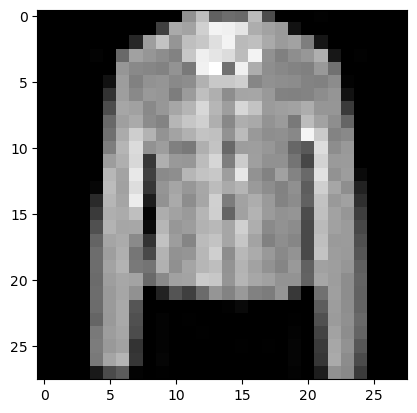


Real answer: Coat
Model answer: Coat

Result:
Model response is correct



In [4]:
image_number = 10
image, label = valset[image_number]
print(f"Class: {class_names_dict[label]}")
plt.imshow(image.squeeze(),cmap='gray')
plt.show()

# predict
outputs = model(valset[image_number][0].to(device).unsqueeze(0))
_, predicted = torch.max(outputs, dim=1)

# validate
real_answer = class_names_dict[valset[image_number][1]]
model_answer = class_names_dict[predicted.item()]
if real_answer == model_answer:
    result = 'correct'
else:
    result = 'incorrect'
    
print(f"""
Real answer: {real_answer}
Model answer: {model_answer}

Result:
Model response is {result}
""")

# 2. Natural Language Processing (NLP) 